In [ ]:
#Sift não esta mais disponível acima desta versão da opencv

!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import cv2 as cv

#Lista 4

### André dos Santos e Lael Santa Rosa

### Questão 1

Leia o seguinte tutorial de calibração de câmera:
https://docs.opencv.org/4.5.2/dc/dbb/tutorial_py_calibration.html

Adapte o código do tutorial e implemente um programa que funcione o mais próximo possível do tempo real com imagens adquiridas por uma webcam ou smartphone. Você vai precisar de um tabuleiro de xadrez (se não tiver um, pode imprimir uma imagem numa folha A4, e colar num papelão ou emplastificar para a geometria ficar fixa).

Exiba na tela a matriz intrínseca, e os vetores de rotação e translação da câmera em tempo real, enquanto varia a posição da câmera, mantendo o tabuleiro sempre visível na imagem. Salve
o vídeo e o print da tela.


Resposta: https://drive.google.com/drive/folders/1Jl-DLU4tJrjyHjtK3JbECmsxf9RLQLeM?usp=sharing

### Questão 2

As fotografias em modo retrato se popularizaram nos  ́ultimos anos Elas consistem em segmentar foreground e background em uma fotografia, e borrar o background, simulando o efeito de uma câmera DLSR, como na imagem abaixo.

[Foto]

O objetivo dessa questão é simular este efeito, usando mapas de disparidade gerados por duas imagens. Para um tutorial de como gerar mapas de disparidade usando OpenCV, veja https://docs.opencv.org/4.5.2/dd/d53/tutorial_py_depthmap.html. Após a aquisição do mapa de disparidade, você deve usá-lo adequadamente para detectar o foreground, aplicar um filtro gaussiano para borrar apenas o background, e combinar as duas  partes para obter um efeito como na figura acima. Experimente seu algoritmo em três pares de imagens adquiridas através de pequenas variações de ponto de vista da câmera.

In [ ]:
!mkdir -p /content/images/q2
!gdown 1GCk3t4z77PuO1uXCB_hJAPtvYUBbDsKw
!unzip -qq ImagensLista4th.zip -d /content/images
!rm -f /content/ImagensLista4th.zip

In [ ]:
def plot_images(imL, imR, disp):

  plt.figure(figsize=(15, 12))

  plt.subplot(1,3,1)
  plt.imshow(imL, cmap='gray')
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(imR, cmap='gray')
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(disp, cmap='gray')
  plt.axis('off')

  plt.show()

def soft_blur_with_mask(image: np.ndarray, mask: np.ndarray):

    cnts = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        x,y,w,h = cv.boundingRect(c)
        ROI = image[y:y+h, x:x+w]
        image[y:y+h, x:x+w] = cv.GaussianBlur(ROI, (5,5), 0)

    return image

In [ ]:
def detecting_keypoints(img1, img2):

  sift = cv.xfeatures2d.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des1, des2, k=2)

  matchesMask = [[0, 0] for i in range(len(matches))]
  good = []
  pts1 = []
  pts2 = []

  for i, (m, n) in enumerate(matches):
      if m.distance < 0.7*n.distance:
          matchesMask[i] = [1, 0]
          good.append(m)
          pts2.append(kp2[m.trainIdx].pt)
          pts1.append(kp1[m.queryIdx].pt)

  draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv.DrawMatchesFlags_DEFAULT)

  keypoint_matches = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, matches[300:500], None, **draw_params)

  return pts1, pts2

def stereo_rectification(img1, img2, pts1, pts2):

  pts1 = np.int32(pts1)
  pts2 = np.int32(pts2)

  fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

  pts1 = pts1[inliers.ravel() == 1]
  pts2 = pts2[inliers.ravel() == 1]

  h1, w1 = img1.shape
  h2, w2 = img2.shape
  _, H1, H2 = cv.stereoRectifyUncalibrated(
      np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
  )

  img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
  img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))

  return img1_rectified, img2_rectified


def depth_map(img1_undistorted, img2_undistorted, block_size=11):

  min_disp = -64
  max_disp = 64
  num_disp = max_disp - min_disp
  uniquenessRatio = 5
  speckleWindowSize = 200
  speckleRange = 2
  disp12MaxDiff = 0

  stereo = cv.StereoSGBM_create(
      minDisparity=min_disp,
      numDisparities=num_disp,
      blockSize=block_size,
      uniquenessRatio=uniquenessRatio,
      speckleWindowSize=speckleWindowSize,
      speckleRange=speckleRange,
      disp12MaxDiff=disp12MaxDiff,
      P1=8 * 1 * block_size * block_size,
      P2=32 * 1 * block_size * block_size,
  )
  disparity_SGBM = stereo.compute(img1_undistorted, img2_undistorted)
  disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                                beta=0, norm_type=cv.NORM_MINMAX)
  disparity_SGBM = np.uint8(disparity_SGBM)
  return disparity_SGBM

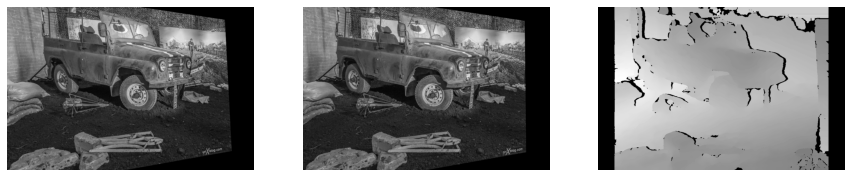

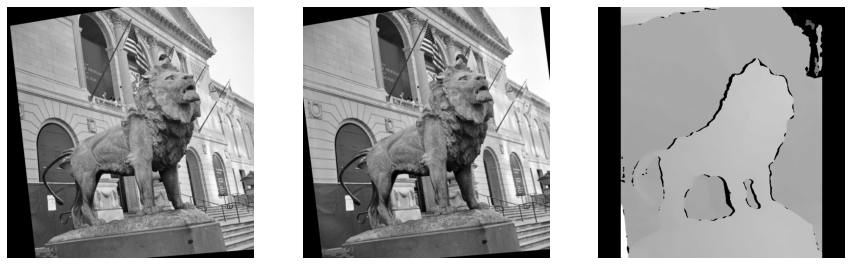

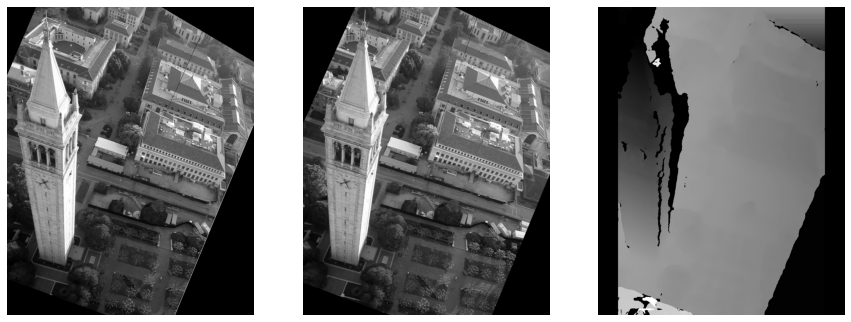

In [ ]:
for path in glob("/content/images/q2/*L*"):

  imgL = cv.imread(path, cv.IMREAD_GRAYSCALE)
  imgR = cv.imread(path.replace("L.","R."), cv.IMREAD_GRAYSCALE)

  imgR = cv.resize(imgR, (imgL.shape[1], imgL.shape[0]))

  pts1, pts2 = detecting_keypoints(imgL.copy(), imgR.copy())
  img1_rectified, img2_rectified = stereo_rectification(imgL.copy(), imgR.copy(), pts1, pts2)

  disp = depth_map(img1_rectified, img2_rectified, 17)
  plot_images(img1_rectified, img2_rectified, disp)

# Questão 3

Com a experiência (e códigos) resultantes das questões anteriores, o objetivo agora é realizar reconstrução 3D. Leia cuidadosamente o tutorial em três partes que pode ser encontrado com código em https://becominghuman.ai/stereo-3d-reconstruction-with-opencv-using-an-iphone-camera-part-i-c013907d1ab5. A parte 3 é a mais importante. Gere três exemplos de reconstruções 3D em formato .ply. Você deve submeter os arquivos ply e imagens com visualizações destas reconstruções, usando o software MeshLab, que pode ser baixado em https://www.meshlab.net.